In [ ]:
%%capture
!wget "https://drive.google.com/uc?export=download&id=1AYKP7N8d-RR_hY5jEM3qxF1n0CGsnUkd&confirm=yes" -O "kaggle.json"
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download bulentsiyah/semantic-drone-dataset
!unzip semantic-drone-dataset.zip -d data

!pip install -q segmentation-models-pytorch
!pip install -q torchsummary

In [ ]:
import os
import torch
import numpy as np 
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt

from PIL import Image
from torch.utils.data import DataLoader
from dataset import DroneDataset, DroneTestDataset

from sklearn.model_selection import train_test_split
import segmentation_models_pytorch as smp
from torchsummary import summary


import cv2
import albumentations as A

from model.metrics import plot_score, plot_acc, plot_loss
from model import SegModel
from model.display_pred import display_results

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

IMAGE_PATH = 'data/dataset/semantic_drone_dataset/original_images/'
MASK_PATH = 'data/dataset/semantic_drone_dataset/label_images_semantic/'

     |████████████████████████████████| 97 kB 7.4 MB/s 
     |████████████████████████████████| 58 kB 7.3 MB/s 
     |████████████████████████████████| 376 kB 61.9 MB/s 


In [ ]:
n_classes = 23 

def create_df():
    name = []
    for dirname, _, filenames in os.walk(IMAGE_PATH):
        for filename in filenames:
            name.append(filename.split('.')[0])
    
    return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

df = create_df()
print('Total Images: ', len(df))

Total Images:  400


In [ ]:
X_trainval, X_test = train_test_split(df['id'].values, test_size=0.08, random_state=19)
X_train, X_val = train_test_split(X_trainval, test_size=0.05, random_state=19)

print('Train Size   : ', len(X_train))
print('Val Size     : ', len(X_val))
print('Test Size    : ', len(X_test))

Train Size   :  349
Val Size     :  19
Test Size    :  32


Image Size (4000, 6000, 3)
Mask Size (4000, 6000)


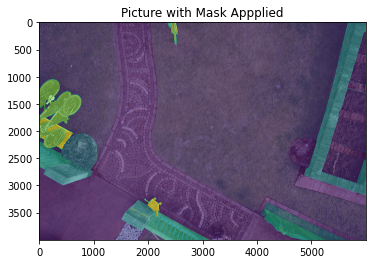

In [ ]:
img = Image.open(IMAGE_PATH + df['id'][99] + '.jpg')
mask = Image.open(MASK_PATH + df['id'][99] + '.png')
print('Image Size', np.asarray(img).shape)
print('Mask Size', np.asarray(mask).shape)

plt.imshow(img)
plt.imshow(mask, alpha=0.6)
plt.title('Picture with Mask Appplied')
plt.show()

In [ ]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

t_train = A.Compose(
    [
        A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST),
        A.HorizontalFlip(),
        A.VerticalFlip(), 
        A.GridDistortion(p=0.2),
        A.RandomBrightnessContrast((0,0.5),(0,0.5)),
        A.GaussNoise()
    ]
)

t_val = A.Compose(
    [
        A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST),
        A.HorizontalFlip(),
        A.GridDistortion(p=0.2)
    ]
)

train_set = DroneDataset(IMAGE_PATH, MASK_PATH, X_train, mean, std, t_train)
val_set = DroneDataset(IMAGE_PATH, MASK_PATH, X_val, mean, std, t_val)

# Model

In [ ]:
# model = smp.Unet(
#     'mobilenet_v2',
#     encoder_weights='imagenet',
#     classes=23,
#     activation=None,
#     encoder_depth=5,
#     decoder_channels=[256, 128, 64, 32, 16]
# )

model = smp.DeepLabV3Plus(
    'efficientnet-b1',
    encoder_weights = 'imagenet',
    classes = 23,
    activation = None,
    encoder_depth = 5,
    decoder_channels = 256
)

seg_model = SegModel(model, device = device)

# Training

In [32]:
#dataloader
batch_size = 4

train_loader = DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True
)
val_loader = DataLoader(
    val_set,
    batch_size=batch_size,
    shuffle=True
)

#training
max_lr = 1e-3
epoch = 25
weight_decay = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))


history = seg_model.fit(epoch, model, train_loader, val_loader, criterion, optimizer, sched)
torch.save(model, 'Unet-Mobilenet.pt')

  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 1.579 
Epoch:1/25.. Train Loss: 2.609.. Val Loss: 1.579.. Train mIoU:0.066.. Val mIoU: 0.128.. Train Acc:0.369.. Val Acc:0.664.. Time: 4.93m


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 1.579 >> 1.010 
Epoch:2/25.. Train Loss: 1.546.. Val Loss: 1.010.. Train mIoU:0.120.. Val mIoU: 0.169.. Train Acc:0.632.. Val Acc:0.730.. Time: 4.88m


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 1.010 >> 0.748 
Epoch:3/25.. Train Loss: 1.104.. Val Loss: 0.748.. Train mIoU:0.174.. Val mIoU: 0.238.. Train Acc:0.699.. Val Acc:0.785.. Time: 4.93m


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.748 >> 0.613 
Epoch:4/25.. Train Loss: 0.863.. Val Loss: 0.613.. Train mIoU:0.262.. Val mIoU: 0.320.. Train Acc:0.754.. Val Acc:0.819.. Time: 4.90m


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Loss Not Decrease
Epoch:5/25.. Train Loss: 0.757.. Val Loss: 0.729.. Train mIoU:0.305.. Val mIoU: 0.311.. Train Acc:0.773.. Val Acc:0.788.. Time: 4.92m


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.729 >> 0.536 
Epoch:6/25.. Train Loss: 0.672.. Val Loss: 0.536.. Train mIoU:0.362.. Val mIoU: 0.405.. Train Acc:0.797.. Val Acc:0.832.. Time: 4.90m


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Loss Not Decrease
Epoch:7/25.. Train Loss: 0.646.. Val Loss: 0.571.. Train mIoU:0.382.. Val mIoU: 0.382.. Train Acc:0.802.. Val Acc:0.831.. Time: 4.95m


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.571 >> 0.467 
Epoch:8/25.. Train Loss: 0.543.. Val Loss: 0.467.. Train mIoU:0.418.. Val mIoU: 0.431.. Train Acc:0.834.. Val Acc:0.855.. Time: 4.93m


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Loss Not Decrease
Epoch:9/25.. Train Loss: 0.567.. Val Loss: 0.480.. Train mIoU:0.422.. Val mIoU: 0.455.. Train Acc:0.823.. Val Acc:0.848.. Time: 4.92m


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.480 >> 0.462 
Epoch:10/25.. Train Loss: 0.455.. Val Loss: 0.462.. Train mIoU:0.460.. Val mIoU: 0.485.. Train Acc:0.857.. Val Acc:0.854.. Time: 4.92m


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.462 >> 0.422 
Epoch:11/25.. Train Loss: 0.419.. Val Loss: 0.422.. Train mIoU:0.485.. Val mIoU: 0.454.. Train Acc:0.868.. Val Acc:0.862.. Time: 4.91m


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.422 >> 0.372 
Epoch:12/25.. Train Loss: 0.393.. Val Loss: 0.372.. Train mIoU:0.507.. Val mIoU: 0.490.. Train Acc:0.877.. Val Acc:0.874.. Time: 4.88m


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.372 >> 0.364 
Epoch:13/25.. Train Loss: 0.362.. Val Loss: 0.364.. Train mIoU:0.519.. Val mIoU: 0.477.. Train Acc:0.885.. Val Acc:0.883.. Time: 4.88m


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.364 >> 0.358 
Epoch:14/25.. Train Loss: 0.371.. Val Loss: 0.358.. Train mIoU:0.517.. Val mIoU: 0.482.. Train Acc:0.882.. Val Acc:0.884.. Time: 4.86m


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.358 >> 0.354 
Epoch:15/25.. Train Loss: 0.330.. Val Loss: 0.354.. Train mIoU:0.542.. Val mIoU: 0.501.. Train Acc:0.893.. Val Acc:0.886.. Time: 4.85m


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.354 >> 0.345 
Epoch:16/25.. Train Loss: 0.364.. Val Loss: 0.345.. Train mIoU:0.531.. Val mIoU: 0.506.. Train Acc:0.882.. Val Acc:0.889.. Time: 4.81m


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.345 >> 0.317 
Epoch:17/25.. Train Loss: 0.315.. Val Loss: 0.317.. Train mIoU:0.548.. Val mIoU: 0.546.. Train Acc:0.898.. Val Acc:0.895.. Time: 4.81m


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.317 >> 0.281 
Epoch:18/25.. Train Loss: 0.290.. Val Loss: 0.281.. Train mIoU:0.565.. Val mIoU: 0.529.. Train Acc:0.905.. Val Acc:0.909.. Time: 4.78m


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Loss Not Decrease
Epoch:19/25.. Train Loss: 0.282.. Val Loss: 0.293.. Train mIoU:0.572.. Val mIoU: 0.551.. Train Acc:0.908.. Val Acc:0.904.. Time: 4.81m


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Loss Not Decrease
Epoch:20/25.. Train Loss: 0.272.. Val Loss: 0.295.. Train mIoU:0.576.. Val mIoU: 0.522.. Train Acc:0.911.. Val Acc:0.903.. Time: 4.81m


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.295 >> 0.291 
Epoch:21/25.. Train Loss: 0.256.. Val Loss: 0.291.. Train mIoU:0.588.. Val mIoU: 0.592.. Train Acc:0.915.. Val Acc:0.905.. Time: 4.82m


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Loss Not Decrease
Epoch:22/25.. Train Loss: 0.250.. Val Loss: 0.299.. Train mIoU:0.586.. Val mIoU: 0.548.. Train Acc:0.917.. Val Acc:0.902.. Time: 4.77m


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.299 >> 0.297 
Epoch:23/25.. Train Loss: 0.250.. Val Loss: 0.297.. Train mIoU:0.592.. Val mIoU: 0.549.. Train Acc:0.917.. Val Acc:0.903.. Time: 4.79m


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.297 >> 0.291 
Epoch:24/25.. Train Loss: 0.248.. Val Loss: 0.291.. Train mIoU:0.591.. Val mIoU: 0.544.. Train Acc:0.918.. Val Acc:0.904.. Time: 4.82m


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.291 >> 0.286 
Epoch:25/25.. Train Loss: 0.249.. Val Loss: 0.286.. Train mIoU:0.591.. Val mIoU: 0.559.. Train Acc:0.918.. Val Acc:0.906.. Time: 4.78m
Total time: 121.55 m


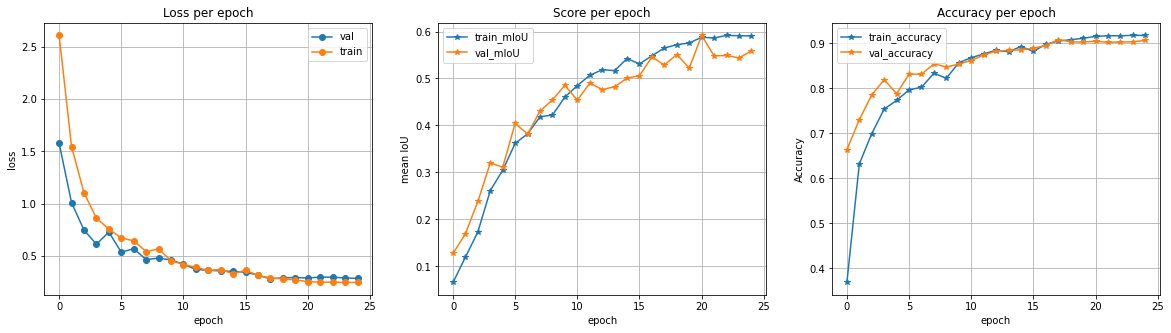

In [33]:
plt.figure(figsize=(20,5))
plt.subplot(1,3,1); plot_loss(history)
plt.subplot(1,3,2); plot_score(history)
plt.subplot(1,3,3); plot_acc(history)
plt.show()

# Evaluation

In [34]:
t_test = A.Resize(768, 1152, interpolation=cv2.INTER_NEAREST)
test_set = DroneTestDataset(IMAGE_PATH, MASK_PATH, X_test, transform=t_test)

In [36]:
mob_miou = seg_model.miou_score(test_set)
print(f"Test Set mIoU {np.mean(mob_miou):.4f}")

mob_acc = seg_model.pixel_acc(test_set)
print(f"Test Set Pixel Accuracy {np.mean(mob_acc):.4f}")

  0%|          | 0/32 [00:00<?, ?it/s]

Test Set mIoU 0.588314214271361


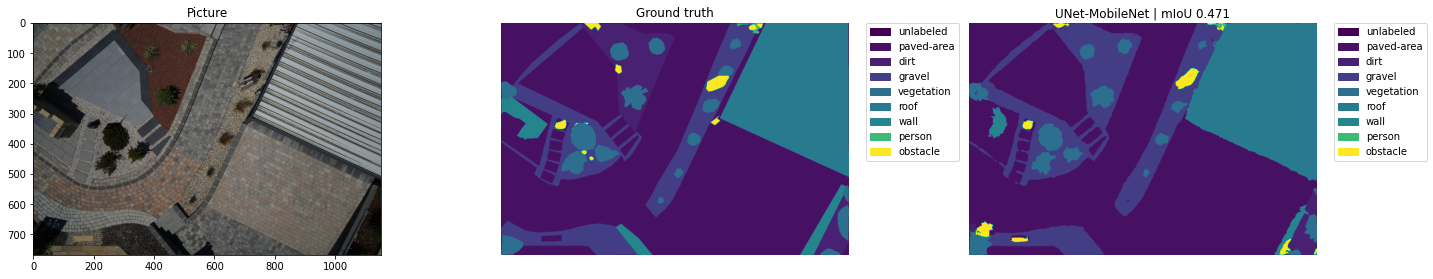

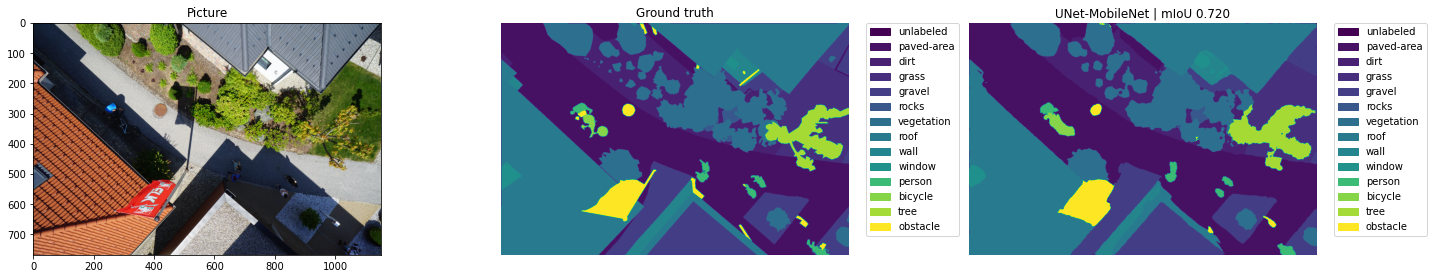

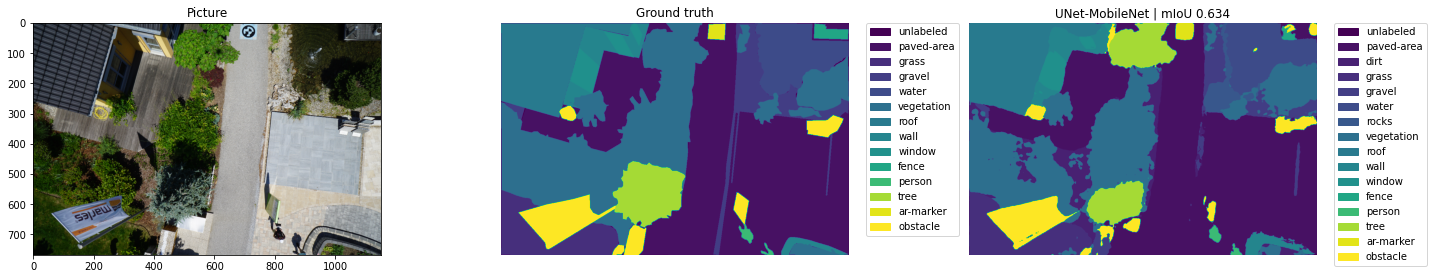

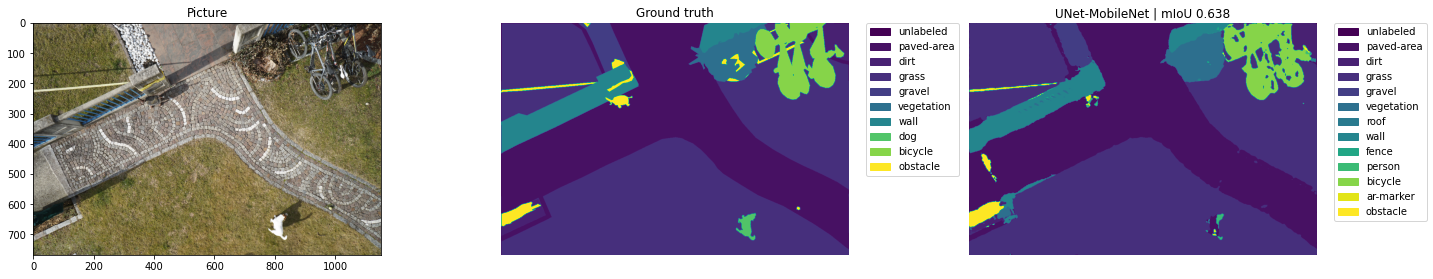

In [40]:
label = pd.read_csv("data/class_dict_seg.csv")

display_results(1, test_set, model)
display_results(2, test_set, model)
display_results(4, test_set, model)
display_results(6, test_set, model)